<a href="https://colab.research.google.com/github/tako21ttp/tako21aiko/blob/main/profitable_ai/ac_01_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[欠陥・疾患判定の自動化 (2値分類と再現率)](https://github.com/makaishi2/profitable_ai_book_info/blob/master/notebooks/ac_01_heart_disease.ipynb)

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [3]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列
    
    # columns 項目名リスト
    n = len(columns)
    
    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

### 項目メモ

#### age
年齢

#### sex
性別
* 1: 男性
* 0: 女性

#### cp
胸痛種別
* 1：典型的な狭心症
* 2：非定型狭心症
* 3：非狭心痛
* 4：無症候性 

#### trestbps
安静時血圧  
（入院時のmm Hg単位）
    
#### chol
血清コレステロール  
（mg / dl）

#### fbs
空腹時血糖   
(> 120 (mg / dl）)
* 1 真
* 0 偽

#### restecg
安静時心電図
 
* 0：通常
* 1：ST-T波異常（T波反転および/またはST上昇または抑圧> 0.05 mV）
* 2：左心室肥大の可能性あり

#### thalach
最大心拍数

#### exang
運動誘発性狭心症
* 1  はい
* 0  いいえ
    
#### oldpeak
ST低下    
(運動により誘発される安静時と比較したST低下)

#### slope
 STセグメント勾配  
(ピーク運動STセグメント勾配)
* 1 上昇
* 2 フラット  
* 3 下降

#### ca 
主要血管数  
(X線透視撮影で着色された主要な血管数（0〜3）)


#### thal
タール  
(タリウム心臓スキャンの結果) 
* 3: 通常
* 6 : 修正された欠陥
* 7 : 回復可能な欠陥


#### num (目的変数)
心臓病診断  
 （血管造影の状態）
* 0: 所見なし
* 1: 所見あり

In [4]:
# 心疾患公開データ読み込み

columns = [
    '年齢', '性別', '胸痛種別', '安静時血圧',  '血清コレステロール',
    '空腹時血糖値', '安静時心電図',  '最大心拍数',  '運動誘発性狭心症',
    'ST低下', 'STセグメント勾配', '主要血管数', 'タール', '心臓病診断'
]

# 公開データセットのURL
url_hu = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
heart-disease/processed.hungarian.data'

# データフレームへの取り込み
# 欠損値は'?'で表現されているので、読み込み時にPythonのNaNに変換する
df_hu = pd.read_csv(url_hu, header=None, names=columns, na_values='?')

In [5]:
# データ全体の確認
display(df_hu.head())

,年齢,性別,胸痛種別,安静時血圧,血清コレステロール,空腹時血糖値,安静時心電図,最大心拍数,運動誘発性狭心症,ST低下,STセグメント勾配,主要血管数,タール,心臓病診断
0,28,1,2,130.0000,132.0000,0.0000,2.0000,185.0000,0.0000,0.0000,NaN,NaN,NaN,0
1,29,1,2,120.0000,243.0000,0.0000,0.0000,160.0000,0.0000,0.0000,NaN,NaN,NaN,0
2,29,1,2,140.0000,NaN,0.0000,0.0000,170.0000,0.0000,0.0000,NaN,NaN,NaN,0
3,30,0,1,170.0000,237.0000,0.0000,1.0000,170.0000,0.0000,0.0000,NaN,NaN,6.0000,0
4,31,0,2,100.0000,219.0000,0.0000,1.0000,150.0000,0.0000,0.0000,NaN,NaN,NaN,0


In [6]:
# 学習データ件数と項目数確認
print(df_hu.shape)
print()

# 「心臓病診断」の値の分布確認
print(df_hu['心臓病診断'].value_counts())
print()

# 所見あり比率
rate = df_hu['心臓病診断'].value_counts()[1]/len(df_hu)
print(f'有症率: {rate:.4f}')

(294, 14)

0    188
1    106
Name: 心臓病診断, dtype: int64

有症率: 0.3605


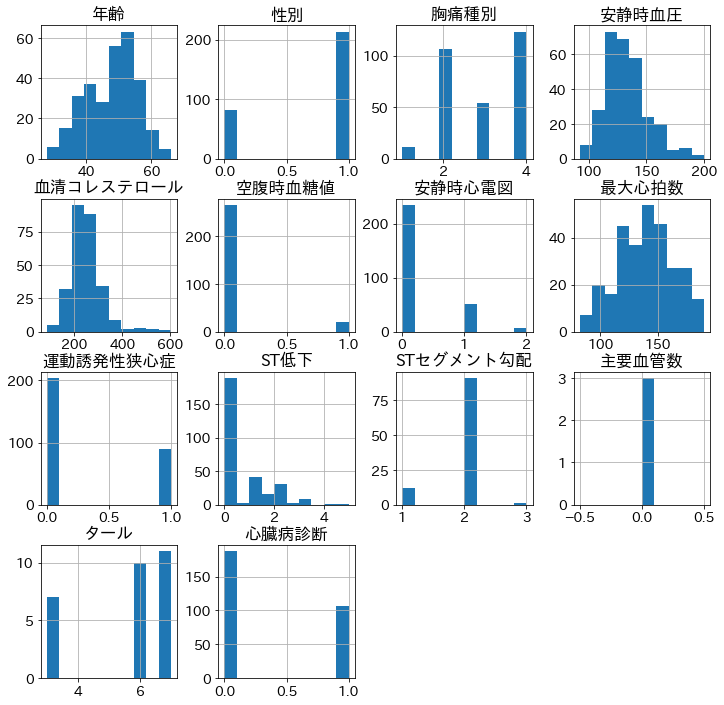

In [7]:
# ヒストグラム表示

# グラフのサイズ調整のためのおまじない
from pylab import rcParams
rcParams['figure.figsize'] = (12, 12)

# データフレームの数値項目でヒストグラム表示
df_hu.hist()
plt.show()

In [8]:
# 欠損値確認
print(df_hu.isnull().sum())

年齢             0
性別             0
胸痛種別           0
安静時血圧          1
血清コレステロール     23
空腹時血糖値         8
安静時心電図         1
最大心拍数          1
運動誘発性狭心症       1
ST低下           0
STセグメント勾配    190
主要血管数        291
タール          266
心臓病診断          0
dtype: int64


#### データ前処理

#### 欠損値対応方針

* 安静時血圧: 平均値
*  血清コレステロール: 平均値
* 空腹時血糖値: 0
* 安静時心電図: 0
* 最大心拍数: 平均値
* 運動誘発性狭心症: 0   
* STセグメント勾配: 2  
----    
* 主要血管数: 項目ごと落とす
* タール: 項目ごと落とす


In [9]:
# 平均値の計算
ave1 = df_hu['安静時血圧'].mean()
ave2 = df_hu['血清コレステロール'].mean()
ave3 = df_hu['最大心拍数'].mean()

# 結果確認
print(f'安静時血圧: {ave1:.1f}  血清コレステロール: {ave2:.1f}   最大心拍数:{ave3:.1f}')

安静時血圧: 132.6  血清コレステロール: 250.8   最大心拍数:139.1


In [10]:
# 欠損値の置換
df2 = df_hu.fillna(
    {'安静時血圧': ave1,
    '血清コレステロール': ave2,
    '空腹時血糖値': 0,
    '安静時心電図': 0,
    '最大心拍数': ave3,
    '運動誘発性狭心症': 0,
    'STセグメント勾配': 2}
)

# 列の削除
df3 = df2.drop(['主要血管数', 'タール'], axis=1)

In [11]:
# 結果確認
print(df3.isnull().sum())
display(df3.head())

年齢           0
性別           0
胸痛種別         0
安静時血圧        0
血清コレステロール    0
空腹時血糖値       0
安静時心電図       0
最大心拍数        0
運動誘発性狭心症     0
ST低下         0
STセグメント勾配    0
心臓病診断        0
dtype: int64


,年齢,性別,胸痛種別,安静時血圧,血清コレステロール,空腹時血糖値,安静時心電図,最大心拍数,運動誘発性狭心症,ST低下,STセグメント勾配,心臓病診断
0,28,1,2,130.0000,132.0000,0.0000,2.0000,185.0000,0.0000,0.0000,2.0000,0
1,29,1,2,120.0000,243.0000,0.0000,0.0000,160.0000,0.0000,0.0000,2.0000,0
2,29,1,2,140.0000,250.8487,0.0000,0.0000,170.0000,0.0000,0.0000,2.0000,0
3,30,0,1,170.0000,237.0000,0.0000,1.0000,170.0000,0.0000,0.0000,2.0000,0
4,31,0,2,100.0000,219.0000,0.0000,1.0000,150.0000,0.0000,0.0000,2.0000,0


#### データ分割

In [12]:
# 入力データと正解データの分離
x = df3.drop('心臓病診断', axis=1)
y = df3['心臓病診断'].values

# 訓練データと検証データの分離
test_size=0.40

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=test_size, random_state=random_seed,
  stratify=y)

#### アルゴリズム選定